# 0. Importar Librerías

### Imports

In [55]:
import supervision as sv
from roboflow import Roboflow

import os
import cv2
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from imutils.video import FileVideoStream

from sinks.model_sink import ModelSink
from sinks.annotation_sink import AnnotationSink

from tools.video_info import VideoInfo
from tools.write_data import txt_append, write_txt

import roboflow_config


from icecream import ic

### Variables

En el primer ciclo, se toma el video y se procesa con el modelo base del detector, pero en este caso se usa el modelo **yolov8x_cf_v5.pt**, modelo que tiene las clases "person, bus, bicycle, motorcycle, truck, car". Con esto, se obtiene el primer CSV del video, y es el que se va a analizar. Si no se cuentan con modelos entrenados, se utilizaría un modelo pre-entrenado (Ej. **yolov8x.pt**), teniendo en cuenta que estos modelos están entrenados para detectar las 80 clases del dataset Microsoft COCO.

In [22]:
ROOT = Path('D:/Data/MARZO_2024')
SOURCE_FOLDER = ROOT / 'Videos' / 'ARS_C57_C65'
INPUT_VIDEO = 'ARS_Iglesia_Santa_Maria_Magdalena_CAM1_new.mp4'
SOURCE_CSV = ROOT / 'Detections' / 'ARS_C57_C65'
INPUT_CSV = 'ARS_Iglesia_Santa_Maria_Magdalena_CAM1_new_yolov10.csv'

### Información del Video

Se extrae la información básica del video tamaño de la imagen y número total de frames, que serán de utilidad para el análisis de las detecciones.

In [23]:
source_video = f"{SOURCE_FOLDER}/{INPUT_VIDEO}"
source_info, source_flag = VideoInfo.get_source_info(source_video)
source_info.__dict__

{'width': 1920, 'height': 1080, 'fps': 50.0, 'total_frames': 44273}

# 1. Leer Archivo CSV

In [24]:
# Load input parameters
source: str = f"{SOURCE_CSV}/{INPUT_CSV}"
with open(source, 'r') as csv_file:
    csv_data = pd.read_csv(
        filepath_or_buffer=csv_file,
        sep=',',
        names=['frame', 'id', 'class', 'x', 'y', 'w', 'h', 'score'],
        header=None,
        index_col=False
    )
csv_data

,frame,id,class,x,y,w,h,score
0,0,NaN,bus,1197.24300,147.846130,277.091670,379.866640,0.933028
1,0,NaN,person,586.74347,388.813570,54.693237,174.161400,0.890133
2,0,NaN,car,383.26636,970.958300,359.427980,106.166440,0.882611
3,0,NaN,person,233.11871,665.194600,82.070496,253.214600,0.879351
4,0,NaN,truck,611.91770,208.105130,485.663100,639.960600,0.802806
...,...,...,...,...,...,...,...,...
681648,44272,NaN,person,1472.74730,530.998300,51.784180,162.688230,0.150508
681649,44272,NaN,person,1073.26710,38.139600,29.807617,59.003560,0.134416
681650,44272,NaN,person,1076.33250,37.322617,26.459960,42.433320,0.133260
681651,44272,NaN,person,1067.87010,44.734352,22.424683,69.893380,0.126402


# 2. Análisis de Video

Los principales parámetros para analizar del CSV son la clase y el score. Se realiza un primer análisis del video procesado completamente con el detector, con un umbral de detección bajo (threshold = 0.1) para obtener la mayor cantidad de detecciones, incrementando los falsos positivos, pero disminuyendo la pérdida de detecciones.

### Muestras por Categoría

Este análisis permite comprender el balance de las clases con el primer modelo, teniendo en cuenta el umbral de detección y las condiciones de la escena. También permite enfocar la selección de imágenes donde se presenten detecciones de las clases con menos muestras.

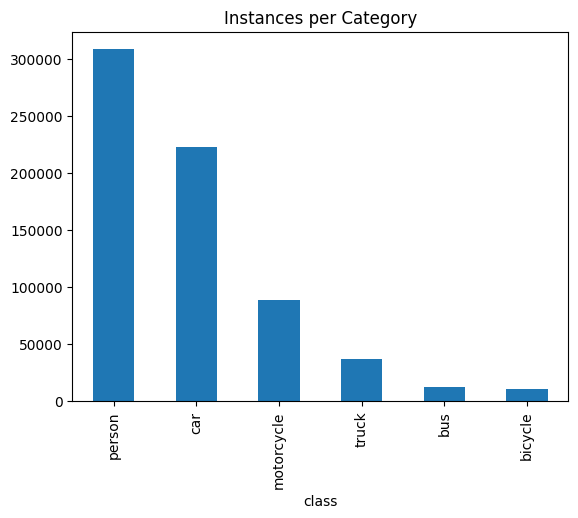

In [25]:
class_count = csv_data['class'].value_counts()
class_count.plot(kind='bar')
plt.title('Instances per Category')
plt.show()

### Análisis general

Para entender con más detalle la detección, se observa el comportamiento por imágenes / frames de las detecciones. Este comportamiento estará determinado por el número de detecciones, las clases detectadas, y el promedio del score, por imagen / frame.

In [26]:
data_analysis = csv_data.groupby('frame').agg(detection_number=('frame', 'size'),classes=('class', lambda x: list(x.unique())),class_number=('class',lambda x: len(list(x.unique()))),mean_score=('score', 'mean')).reset_index()
data_analysis

,frame,detection_number,classes,class_number,mean_score
0,0,17,"[bus, person, car, truck]",4,0.525420
1,1,17,"[bus, person, car, truck]",4,0.540096
2,2,18,"[bus, person, car, truck, bicycle]",5,0.532540
3,3,18,"[person, car, bus, truck, motorcycle]",5,0.525020
4,4,19,"[car, person, truck, bus, motorcycle]",5,0.498484
...,...,...,...,...,...
44268,44268,15,"[car, person, bus, motorcycle]",4,0.451231
44269,44269,15,"[car, person, bus, motorcycle]",4,0.455761
44270,44270,16,"[car, person, bus, motorcycle]",4,0.428436
44271,44271,18,"[car, person, bus, motorcycle]",4,0.392288


### Clases por imagen / frame

Se observa el número de clases únicas detectadas por el número de imágenes que componen el dataset o el número de frames del video. Permite entender la variedad de clases presentes en el video y la cantidad de imágenes que podrían aportar todas las clases en una sola imagen, favoreciendo a la selección de imágenes que aporten más información de clases.

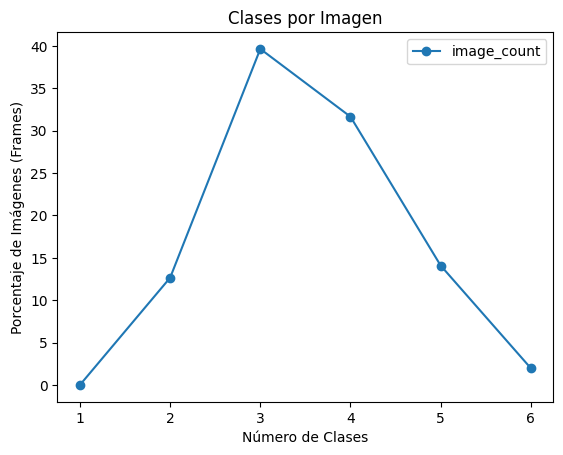

In [27]:
image_class_count = data_analysis.groupby('class_number').agg(image_count=('frame','count'))
image_class_percentage = image_class_count / source_info.total_frames * 100
image_class_percentage.plot(marker='o')
plt.title('Clases por Imagen')
plt.xlabel('Número de Clases')
plt.ylabel('Porcentaje de Imágenes (Frames)')
plt.show()

### Detecciones por imagen / frame

Se observa el número de detecciones por el número de imágenes que componen el dataset o el número de frames del video. Permite entender la cantidad de imágenes que más detecciones tienen, y por lo tanto, podrían aportar más información al detector. Se debe tener en cuenta que son detecciones de todas las clases y se pueden presentar casos de muchas detecciones de solo 1 clase o casos de 1 detección por clase.

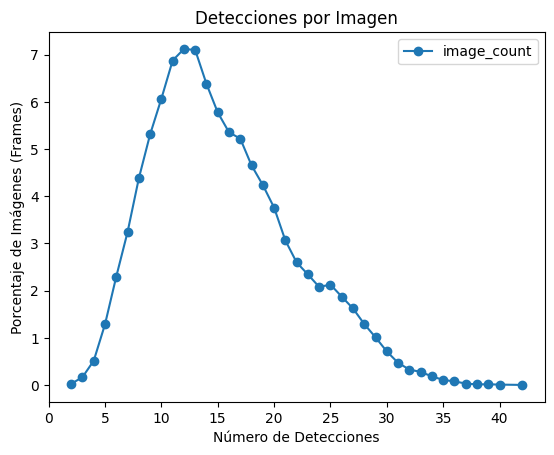

In [28]:
image_instance_count = data_analysis.groupby('detection_number').agg(image_count=('frame','count'))
image_instance_percentage = image_instance_count / source_info.total_frames * 100
image_instance_percentage.plot(marker='o')
plt.title('Detecciones por Imagen')
plt.xlabel('Número de Detecciones')
plt.ylabel('Porcentaje de Imágenes (Frames)')
plt.show()

# 3. Selección de Imágenes / Frames

Es de interés general seleccionar las imágenes que más aporten al entrenamiento de un nuevo modelo. Para esto, con el análisis anterior, se seleccionan las imágenes que contengan más muestras, que más clases, y cuyo score medio sea bajo.

En el caso particular que se busque mejorar la detección de algunas clases, como personas o bicicletas, o de clases con baja representación en el dataset / video, se seleccionan aquellas con el mismo comportamiento, pero para las clases particulares.

### Filtro de máximo valor

Se quitan imágenes cuyo score medio es superior a un umbral, asumiendo que son imágenes en las que el detector ha funcionado de manera correcta.

In [29]:
data_underscores = data_analysis[data_analysis['mean_score'] <= 0.75]
data_underscores = data_underscores.sort_values('mean_score', ascending=True)
data_underscores

,frame,detection_number,classes,class_number,mean_score
41310,41310,9,"[car, person, truck, motorcycle]",4,0.203155
36809,36809,10,"[car, motorcycle, person]",3,0.222961
36850,36850,15,"[car, person, motorcycle, bicycle]",4,0.225165
36808,36808,12,"[car, person, motorcycle]",3,0.225871
36806,36806,12,"[car, person, motorcycle]",3,0.226756
...,...,...,...,...,...
34597,34597,11,"[car, person]",2,0.749629
17337,17337,13,"[car, person, motorcycle]",3,0.749707
42756,42756,7,"[car, bus, person, bicycle]",4,0.749781
25654,25654,17,"[car, person, motorcycle]",3,0.749790


### Filtro de clases

Se dejan las imágenes en las que haya habido detecciones de personas y bicicletas, como clases de interés.

In [30]:
data_classfilter = data_underscores[data_underscores['classes'].apply(lambda x: 'person' in x or 'bicycle' in x)]
data_classfilter

,frame,detection_number,classes,class_number,mean_score
41310,41310,9,"[car, person, truck, motorcycle]",4,0.203155
36809,36809,10,"[car, motorcycle, person]",3,0.222961
36850,36850,15,"[car, person, motorcycle, bicycle]",4,0.225165
36808,36808,12,"[car, person, motorcycle]",3,0.225871
36806,36806,12,"[car, person, motorcycle]",3,0.226756
...,...,...,...,...,...
34597,34597,11,"[car, person]",2,0.749629
17337,17337,13,"[car, person, motorcycle]",3,0.749707
42756,42756,7,"[car, bus, person, bicycle]",4,0.749781
25654,25654,17,"[car, person, motorcycle]",3,0.749790


### Orden de las imágenes

Se ordena el conjunto de imágenes teniendo en cuenta número de detecciones y clases, con un bajo score medio.

In [31]:
data_sorted_1 = data_classfilter.sort_values(['detection_number', 'mean_score'], ascending=[False, True])
data_sorted_1

,frame,detection_number,classes,class_number,mean_score
32684,32684,42,"[car, person, truck, motorcycle, bus]",5,0.393099
32689,32689,40,"[car, person, truck, motorcycle, bus, bicycle]",6,0.389598
32690,32690,40,"[car, person, truck, motorcycle, bicycle, bus]",6,0.405754
32682,32682,40,"[car, person, truck, motorcycle, bus]",5,0.411128
32703,32703,40,"[car, person, truck, motorcycle, bus, bicycle]",6,0.412107
...,...,...,...,...,...
41436,41436,3,"[car, person]",2,0.627805
41734,41734,3,"[person, truck]",2,0.667904
41735,41735,3,"[person, truck]",2,0.680299
13079,13079,3,"[car, truck, person]",3,0.691884


### Selección de imágenes

Con este resultado, se selección el top 40 de imágenes, serán aquellas con mayor cantidad de detección y score medio más bajo.

In [32]:
image_subset_1 = data_sorted_1.head(40)
image_subset_1

,frame,detection_number,classes,class_number,mean_score
32684,32684,42,"[car, person, truck, motorcycle, bus]",5,0.393099
32689,32689,40,"[car, person, truck, motorcycle, bus, bicycle]",6,0.389598
32690,32690,40,"[car, person, truck, motorcycle, bicycle, bus]",6,0.405754
32682,32682,40,"[car, person, truck, motorcycle, bus]",5,0.411128
32703,32703,40,"[car, person, truck, motorcycle, bus, bicycle]",6,0.412107
2413,2413,39,"[car, person, truck, motorcycle, bus, bicycle]",6,0.359041
15586,15586,39,"[car, person, motorcycle, truck, bicycle, bus]",6,0.404573
32685,32685,39,"[car, person, truck, motorcycle]",4,0.406375
32697,32697,39,"[car, person, truck, motorcycle, bus]",5,0.416096
32680,32680,39,"[car, person, truck, motorcycle, bus]",5,0.428586


# 4. Análisis de subconjunto de imágenes

Se realiza un análisis para entender las imágenes seleccionadas y proceder a su envío para revisión de etiquetas.

In [ ]:
car_class = csv_data[csv_data['class'] == 'car'].copy().reset_index()
car_class

In [ ]:
bicycle_mean_score = bicycle_class['score'].min()
bicycle_mean_score


In [ ]:
person_mean_score = person_class['score'].mean()
person_mean_score

In [ ]:
frame_list = object_count['frame'].to_list()
frame_list

# 5. Extracción de frames

Para el caso de videos, se procede a la extracción de los frames, junto con sus detecciones, en formato YOLO, para ser analizados y posteriormente, transferirlos a Roboflow para su revisión y corrección manual.

### Modelo del detector: YOLOv10x

In [79]:
weights = 'D:/Data/models/yolov10/yolov10x.pt'
detection_sink = ModelSink(
    weights_path=weights,
    confidence=0.1,
    class_filter=[0,1,2,3,5,7]
)

### Configuración de las anotaciones en las imágenes

In [80]:
annotation_sink = AnnotationSink(
    source_info=source_info,
    fps=False,
)

In [81]:
frame_list = image_subset_1['frame'].to_list()
frame_list

[32684,
 32689,
 32690,
 32682,
 32703,
 2413,
 15586,
 32685,
 32697,
 32680,
 32677,
 8682,
 32694,
 3259,
 32818,
 32821,
 32676,
 8683,
 15578,
 33356,
 32696,
 32817,
 32705,
 32730,
 32678,
 32704,
 3368,
 8688,
 32712,
 32771,
 32767,
 8681,
 2419,
 3237,
 32615,
 3253,
 32687,
 32686,
 32828,
 32699]

In [92]:
EXTRACT_FOLDER = SOURCE_CSV / 'dataset'
os.mkdir(Path(f"{EXTRACT_FOLDER}"))
os.mkdir(Path(f"{EXTRACT_FOLDER}/labels"))
os.mkdir(Path(f"{EXTRACT_FOLDER}/images"))
os.mkdir(Path(f"{EXTRACT_FOLDER}/detections"))
frame_number = 0
image_name_pattern: str = "image_{:07d}"
video_stream = FileVideoStream(source_video)
video_stream.start()
while video_stream.more():
    output_data = []
    print(f"Frame: {frame_number}")
    image = video_stream.read()
    if image is None:
        print()
        break
    
    if frame_number in frame_list:
        results = detection_sink.detect(image=image)

        output_data = txt_append(output_data, results)

        detections = sv.Detections.from_ultralytics(results)

        annotated_image = annotation_sink.on_detections(detections=detections, image=image)

        write_txt(f'{Path(f"{EXTRACT_FOLDER}/labels/{image_name_pattern.format(frame_number)}")}.txt', output_data)
        cv2.imwrite(f'{Path(f"{EXTRACT_FOLDER}/images/{image_name_pattern.format(frame_number)}")}.png', image)
        cv2.imwrite(f'{Path(f"{EXTRACT_FOLDER}/detections/{image_name_pattern.format(frame_number)}")}.png', annotated_image)
        
    frame_number += 1
video_stream.stop()

Frame: 0
Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
Frame: 7
Frame: 8
Frame: 9
Frame: 10
Frame: 11
Frame: 12
Frame: 13
Frame: 14
Frame: 15
Frame: 16
Frame: 17
Frame: 18
Frame: 19
Frame: 20
Frame: 21
Frame: 22
Frame: 23
Frame: 24
Frame: 25
Frame: 26
Frame: 27
Frame: 28
Frame: 29
Frame: 30
Frame: 31
Frame: 32
Frame: 33
Frame: 34
Frame: 35
Frame: 36
Frame: 37
Frame: 38
Frame: 39
Frame: 40
Frame: 41
Frame: 42
Frame: 43
Frame: 44
Frame: 45
Frame: 46
Frame: 47
Frame: 48
Frame: 49
Frame: 50
Frame: 51
Frame: 52
Frame: 53
Frame: 54
Frame: 55
Frame: 56
Frame: 57
Frame: 58
Frame: 59
Frame: 60
Frame: 61
Frame: 62
Frame: 63
Frame: 64
Frame: 65
Frame: 66
Frame: 67
Frame: 68
Frame: 69
Frame: 70
Frame: 71
Frame: 72
Frame: 73
Frame: 74
Frame: 75
Frame: 76
Frame: 77
Frame: 78
Frame: 79
Frame: 80
Frame: 81
Frame: 82
Frame: 83
Frame: 84
Frame: 85
Frame: 86
Frame: 87
Frame: 88
Frame: 89
Frame: 90
Frame: 91
Frame: 92
Frame: 93
Frame: 94
Frame: 95
Frame: 96
Frame: 97
Frame: 98
Frame: 99
Frame: 100

KeyboardInterrupt: 

### Construir labelmap

El archivo labelmap permite asignar un ID de clase a un nombre de clase, para el etiquetado.

In [83]:
dataset_names= {
    0: 'bicycle',
    1: 'bus',
    2: 'car',
    3: 'motorbike',
    4: 'person',
    5: 'truck'
}
for values in dataset_names.values():
    with open(f"{EXTRACT_FOLDER}/labelmap.txt", 'a') as txt_file:
        txt_file.write(f"{values}\n")

# Transferencia a Roboflow

Con las imágenes generadas, se procede a la creación del conjunto de imágenes para etiquetar en Roboflow.

### Configuración de Roboflow

Se guarda en el archivo de configuración roboflow_config.py, la API_KEY para acceder al usuario. Con esto, se accede al ambiente de trabajo.

In [84]:
rf = Roboflow(api_key=roboflow_config.API_KEY)
print(rf.workspace())

loading Roboflow workspace...
{
  "name": "Carlos Andr\u00e9s Wilches P\u00e9rez",
  "url": "carlos-andres-wilches-perez",
  "projects": [
    "carlos-andres-wilches-perez/camaras_fijas",
    "carlos-andres-wilches-perez/cct-drone",
    "carlos-andres-wilches-perez/elementos-de-proteccion-personal-id6zs",
    "carlos-andres-wilches-perez/tejo-tracking",
    "carlos-andres-wilches-perez/videos_2024"
  ]
}


### Configuración del dataset

Accediendo al ambiente de trabajo, se pasa a configurar el proyecto donde se guardarán las imágenes.

In [85]:
PROJECT_ID = 'videos_2024'
project = rf.workspace().project(PROJECT_ID)
print(project)

loading Roboflow workspace...
loading Roboflow project...
{
  "name": "videos_2024",
  "type": "object-detection",
  "workspace": "carlos-andres-wilches-perez"
}


In [86]:
images = os.listdir(Path(f"{EXTRACT_FOLDER}/images"))
for image in images:
    print(Path(image).stem)
    project.single_upload(
        batch_name='video1',
        image_path=f"{EXTRACT_FOLDER}/images/{Path(image).stem}.png",
        annotation_path=f"{EXTRACT_FOLDER}/labels/{Path(image).stem}.txt",
        annotation_labelmap=f"{EXTRACT_FOLDER}/labelmap.txt",
    )

image_0002413
image_0002419
image_0003237
image_0003253
image_0003259
image_0003368
image_0008681
image_0008682
image_0008683
image_0008688
image_0015578
image_0015586
image_0032615
image_0032676
image_0032677
image_0032678
image_0032680
image_0032682
image_0032684
image_0032685
image_0032686
image_0032687
image_0032689
image_0032690
image_0032694
image_0032696
image_0032697
image_0032699
image_0032703
image_0032704
image_0032705
image_0032712
image_0032730
image_0032767
image_0032771
image_0032817
image_0032818
image_0032821
image_0032828
image_0033356
